# Conformal Prediction
> Tutorial on how to train neuralforecast models and obtain prediction intervals using the conformal prediction methods

Conformal prediction uses cross-validation on a model trained with a point loss function to generate prediction intervals. No additional training is needed, and the model is treated as a black box. The approach is compatible with any model.

In this notebook, we demonstrate how to obtain prediction intervals using conformal prediction.

## Load libraries

In [ ]:
import logging
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.models import NLinear
from neuralforecast.utils import AirPassengersPanel
from neuralforecast.utils import ConformalIntervals
from neuralforecast.losses.pytorch import DistributionLoss


In [ ]:
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
os.environ['NIXTLA_ID_AS_COL'] = '1'

## Data

We simply use the AirPassengers dataset for the demonstration of conformal prediction.


In [ ]:
AirPassengersPanel_train = AirPassengersPanel[AirPassengersPanel['ds'] < AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test = AirPassengersPanel[AirPassengersPanel['ds'] >= AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test['y'] = np.nan
AirPassengersPanel_test['y_[lag12]'] = np.nan

## Model training

We now train a NHITS model on the above dataset. To support conformal predictions, we must first instantiate the `ConformalIntervals` class and pass this to the `fit` method. By default, `ConformalIntervals` class employs `n_windows=2` for the corss-validation during the computation of conformity scores. We also train a MLP model using DistributionLoss to demonstate the difference between conformal prediction and quantiled outputs. 

<br>

By default, `ConformalIntervals` class employs method=conformal_distribution for the conformal predictions. `method=conformal_error` is also supported. The `conformal_distribution` method calculates forecast paths using the absolute errors and based on them calculates quantiles. The `conformal_error` calculates quantiles directly from errors.


In [ ]:
horizon = 12
input_size = 24

conformal_intervals = ConformalIntervals()

models = [NHITS(h=horizon, input_size=input_size, max_steps=100), NHITS(h=horizon, input_size=input_size, max_steps=100, loss=DistributionLoss("Normal", level=[10, 50, 90]))]
nf = NeuralForecast(models=models, freq='ME')
nf.fit(AirPassengersPanel_train, conformal_intervals=conformal_intervals)

Seed set to 1
Seed set to 1


/root/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/root/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/root/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, v_num=31, train_loss_step=14.40, train_loss_epoch=14.40]

/root/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.94it/s]
                                                                             

/root/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/root/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/root/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, v_num=36, train_loss_step=5.640, train_loss_epoch=5.640]   


## Forecasting

To generate conformal intervals, we specify the desired levels in the `predict` method. Note that in the following example, predictions labeled by `NHITS1` refer to the predictions by model using `DistributionLoss` loss function, which compute the intervals in quantiled manner. Predictions labeled with 'MODEL-conformal-lo/hi-#' are computed by conformal predictions meanwhile those labeled with 'MODEL-lo/hi-#' are computed in quantiled manner. 

If we want to conformalize quantiled outputs, we need to set `ConformalIntervals(enable_quantiles=True)`.

In [ ]:
preds = nf.predict(futr_df=AirPassengersPanel_test, conformal_level=[10, 50, 90])

/root/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.85it/s]


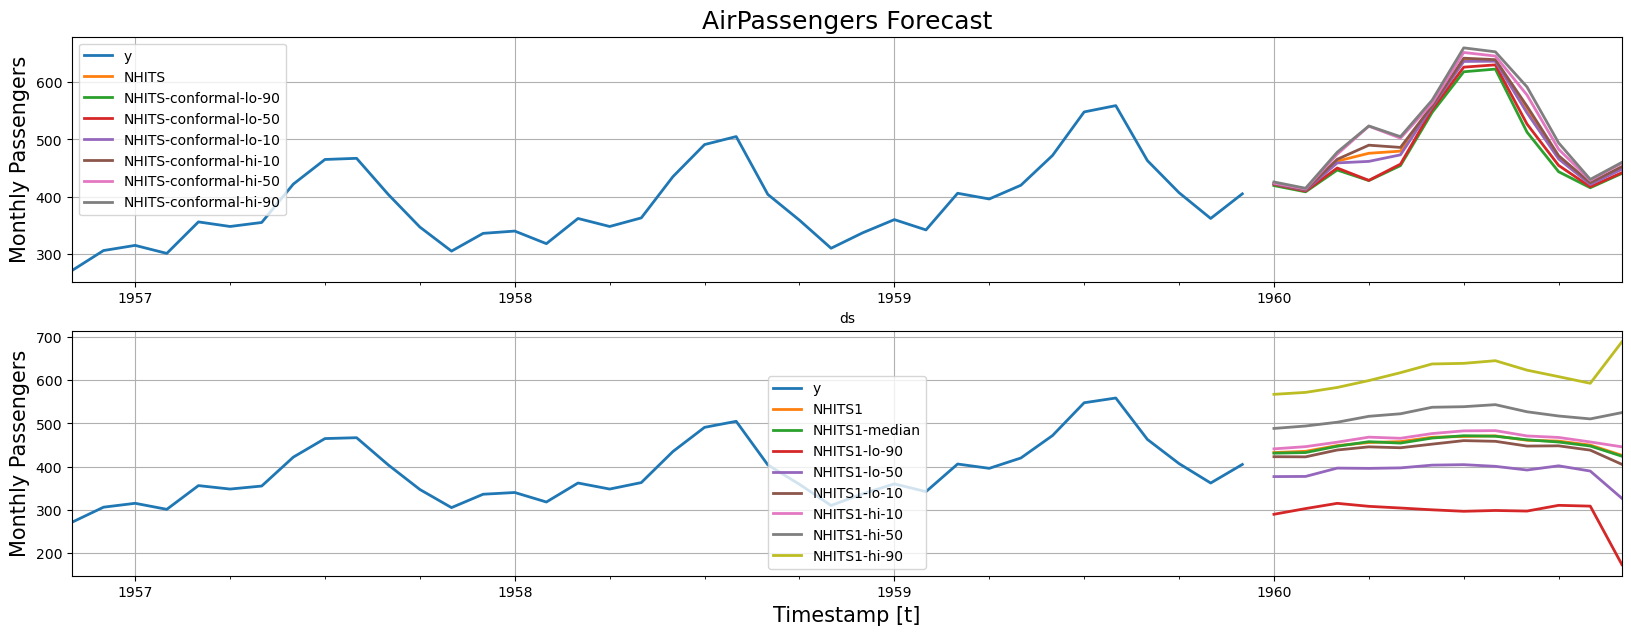

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 7))
plot_df = pd.concat([AirPassengersPanel_train, preds]).set_index('ds')

plot_df = plot_df[plot_df['unique_id']=='Airline1'].drop(['unique_id','trend','y_[lag12]'], axis=1).iloc[-50:]
plot_df.drop([x for x in plot_df.columns if 'NHITS1' in x], axis=1).plot(ax=ax1, linewidth=2)
plot_df.drop([x for x in plot_df.columns if 'NHITS-' in x or x == "NHITS"], axis=1).plot(ax=ax2, linewidth=2)

ax1.set_title('AirPassengers Forecast', fontsize=18)
ax1.set_ylabel('Monthly Passengers', fontsize=15)
ax1.legend(prop={'size': 10})
ax1.grid()
ax2.set_ylabel('Monthly Passengers', fontsize=15)
ax2.set_xlabel('Timestamp [t]', fontsize=15)
ax2.legend(prop={'size': 10})
ax2.grid()
